### VA Diabetes Overview ### 

Problem:

Veterans who receive care in Veterans Health Administration experience and suffer from a higher burden of obesity and diabetes compared to non-Veteran populations. The human and economic costs are staggering as reflected in the recent 2020 Obesity VA/DoD Clinical Practice Guideline Management of Adult Overweight and Obesity and the newly revised 2023 VA/DoD Clinical Practice Guideline Management of Type 2 Diabetes Mellitus. Most patients with diabetes mellitus are asymptomatic, which leads to delayed and more complex treatment.

Research Question: 

Will empowering the veteran with knowledge and simple assessment promote healthier lifestyle choices that address and mitigate risk factors associated with T2DM? 

Research Demographic - Veterans with BMI >= 25

Outcomes we hope to achieve over a 6 - 12 month follow up:

1. Weight loss:
Evaluate percent of patients that achieved 5%;
Evaluate percent of patients that achieved 10%

2. HbA1c reduction:
Evaluate percent of patients that achieved HbA1c less than 6.5%;
Evaluate percent of patients that reduced HbA1c by more than 1%


Objective: 

The prevalence of Type 2 Diabetes Mellitus (T2DM) among veterans is a multifaceted issue. Environmental, genetic and lifestyle interactions have not been fully explored as predeterminants of T2DM. Glycated Hemoglobin (HbA1c) is one of the primary tools to diagnose T2DM. However, often times this is only monitored effectively after the onset of the disease. This research will develop a classification model to proactively identify veterans at high risk for T2DM, providing risk scores that enable earlier interventions and potentially prevent or delay disease development.

### Imports

In [1]:
# Package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

# Retrieve the 'Projects' environment variable
base_dir = os.environ.get('Projects', '/Users/ben/Projects')

# Construct the path to the Excel file
file_path = os.path.join(base_dir, 'VA_diab_review', 'update.xlsx')

In [3]:
# Loading xlsx file into a dataframe
df = (
    pd.read_excel(file_path, sheet_name = 'Sheet1')
    # Dropping columns with 0 non-null count
    .dropna(axis=1, how='all')
    # Lowercasing and replacing spaces with underscores and remove leading spaces in all column names
    .rename(columns=lambda x: x.strip().lower().replace(' ', '_').replace('-', '_'))
)

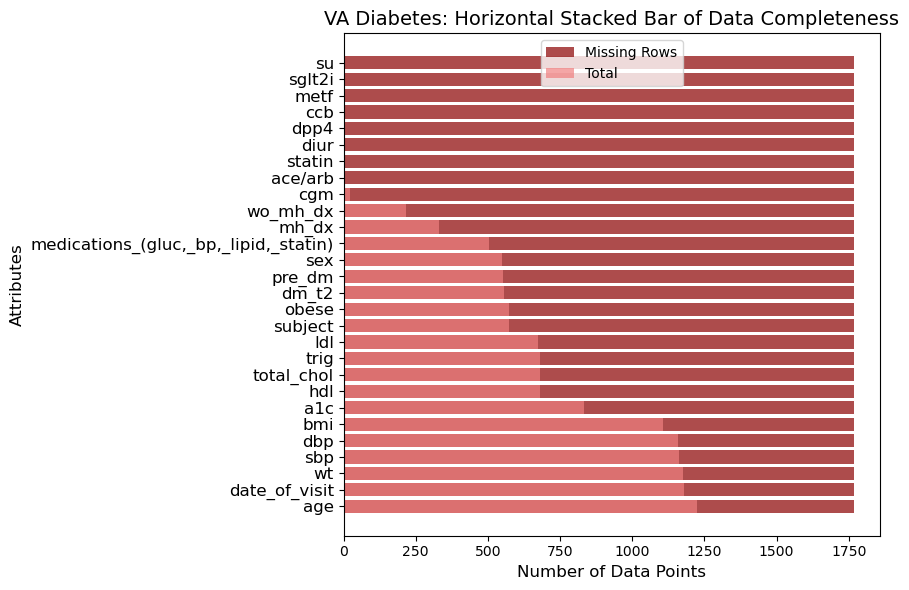

In [4]:
# Calculate non-missing and missing data points
non_missing_data_na = df.notnull().sum()
missing_data_counts_na = df.isnull().sum()

# Update the total number of entries after dropping rows
total_entries_na_updated = len(df)

# Sorting the columns in ascending order
sorted_columns = missing_data_counts_na.sort_values(ascending=True).index

# Create the horizontal stacked bar graph
plt.figure(figsize=(9, 6))
plt.barh(sorted_columns, total_entries_na_updated, label='Missing Rows', color='darkred', alpha=0.7)
plt.barh(sorted_columns, non_missing_data_na[sorted_columns], label='Total', color='lightcoral', alpha=0.7)

plt.ylabel('Attributes', fontsize=12)
plt.xlabel('Number of Data Points', fontsize=12)
plt.title('VA Diabetes: Horizontal Stacked Bar of Data Completeness', fontsize=14)
plt.legend(loc='upper center')
plt.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()

In [5]:
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770 entries, 0 to 1769
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject                                574 non-null    float64
 1   date_of_visit                          1181 non-null   object 
 2   age                                    1225 non-null   float64
 3   sex                                    549 non-null    object 
 4   wt                                     1175 non-null   float64
 5   sbp                                    1161 non-null   float64
 6   dbp                                    1160 non-null   object 
 7   bmi                                    1105 non-null   object 
 8   obese                                  572 non-null    object 
 9   pre_dm                                 553 non-null    object 
 10  dm_t2                                  555 non-null    object 
 11  a1c 

,subject,date_of_visit,age,sex,wt,sbp,dbp,bmi,obese,pre_dm,...,mh_dx,wo_mh_dx,metf,sglt2i,dpp4,su,ccb,ace/arb,diur,statin
1765,NaN,2024-05-30 00:00:00,NaN,NaN,196.0,125.0,81,28.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1767,573.0,2024-05-31 00:00:00,NaN,NaN,190.0,135.0,79,27.3,n,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1769,574.0,2024-06-13 00:00:00,NaN,NaN,243.0,116.0,67,33,y,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cleaning & Transformation

#### Research Audit

    1. drop any nulls subsetting for ['date_of_visit', 'wt', 'a1c']
    2. create visit category for initial and follow up (address research questions)
    3. non-numeric character check necessary for num dtypes that imported as object 
    4. laboratory nulls will not be imputed / outlier check (missing bmi impute by creating ht)
    5. a1c standard for diagnoses; create function to label encode for binary, multi-class / pre_dm and dm_t2 can be dropped
    6. create blood_pressure feature as ordinal EDA / potential drop 
    7. create body_type instead of obese from bmi for EDA / potential drop
    8. drop med columns due to NULLS
     HbA1c Target Labels

        Healthy: Below 5.7%
        Prediabetes: 5.7% to 6.4%
        Diabetes: 6.5% or higher

    blood_pressure

        Normal: SBP is less than 120 and DBP is less than 80.
        Elevated: SBP is between 120 and 129 and DBP is less than 80.
        Hypertension Stage 1: SBP is between 130 and 139 or DBP is between 80 and 89.
        Hypertension Stage 2: SBP is 140 or higher or DBP is 90 or higher.
        Hypertensive Crisis: SBP is above 180 or DBP is above 120.
        UNDETERMINED: Any blood pressure reading that does not fit the above categories

     body_type
        Underweight: BMI less than 18.5
        Normal weight: BMI 18.5 to 24.9
        Overweight: BMI 25 to 29.9
        Obesity: BMI 30 and over

#### Pre-process and Model
    8. date_of_visit, subject can be dropped before modeling 
    9. split dataframe into train/test 
    10. standarize and select classification models for eval



In [6]:
df = df.dropna(subset=['date_of_visit', 'wt', 'a1c'])  # Drop rows with any null in these columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 819 entries, 0 to 1769
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject                                548 non-null    float64
 1   date_of_visit                          819 non-null    object 
 2   age                                    721 non-null    float64
 3   sex                                    524 non-null    object 
 4   wt                                     819 non-null    float64
 5   sbp                                    814 non-null    float64
 6   dbp                                    814 non-null    object 
 7   bmi                                    797 non-null    object 
 8   obese                                  547 non-null    object 
 9   pre_dm                                 540 non-null    object 
 10  dm_t2                                  541 non-null    object 
 11  a1c       

In [7]:
# Address data types of a1c, hdl, and ldl by removing non-numeric characters and converting to float
columns_of_interest = ['bmi','a1c', 'hdl', 'ldl']
unique_values = {col: df[col].unique() for col in columns_of_interest}

unique_values

{'bmi': array([39.07, nan, 34.5, 31.67, 29.9, 29.59, 30.02, 24.7, 32.5, 38.7,
        34.12, 39.3, 30.5, 28, 42.9, 29, 33.8, 31.1, 41, 37.5, 37.7, 29.7,
        33.1, 31.4, 30.7, 29.6, 26.7, 26, 45.8, 40.6, 55.3, 31.5, 28.6, 27,
        33.09, 33.5, 43.1, 45.6, 41.5, 38.4, 36.2, 35.2, 36.6, 44.6, 46,
        31.7, 33.4, 32.8, 35, 35.6, 34.6, 37.6, 30, 25, 42.7, 34.8, 32.1,
        34.1, 38, 33.6, 30.2, 36, 36.9, 35.1, 38.2, 28.7, 35.8, 27.4, 50.5,
        36.4, 36.8, 33.7, 30.3, 29.5, 28.8, 32.6, 40, 34.2, 30.8, 35.5,
        26.8, 34.3, 25.5, 24.3, 27.7, 38.5, 32.4, 34.9, 31.2, 24, 23.5,
        34.7, 41.1, 39.1, 35.3, 36.5, 31, 28.3, 40.5, 41.8, 40.2, 39.9,
        31.8, 43.6, 33.3, 36.1, 46.5, 40.1, 39.7, 50.8, 35.9, 34.4, 45.3,
        42.8, 36.7, 37.2, 32.3, 31.3, 32.9, 29.2, 27.9, 25.2, 28.9, 27.5,
        27.6, 30.9, 33, 30.1, 57.5, 25.6, 30.6, 29.1, 35.4, 42.5, 29.3,
        33.9, 31.6, 39.6, 47.5, 41.2, 37, 33.2, 30.4, 41.7, 41.6, 42, 28.4,
        26.4, 36.3, 40.8, 43, 40.7, 

In [8]:
# Define the function to clean and convert bmi, a1c, ldl, hdl dtypes
def clean_and_convert_columns(df, columns):
    for column in columns:
        # Handle text within parentheses and any textual values for hdl and ldl 
        df[column] = df[column].apply(lambda x: np.nan if isinstance(x, str) and not x.replace('.', '', 1).isdigit() else x)
        # Remove anything within parentheses and convert to float
        df[column] = df[column].astype(str).str.replace(r"\(.*\)", "", regex=True).str.strip().astype(float)
    return df

# Apply the function to clean and convert the columns
columns_to_clean = ['bmi','a1c', 'hdl', 'ldl']
clean_and_convert_columns(df, columns_to_clean)

,subject,date_of_visit,age,sex,wt,sbp,dbp,bmi,obese,pre_dm,...,mh_dx,wo_mh_dx,metf,sglt2i,dpp4,su,ccb,ace/arb,diur,statin
0,1.0,2023-03-27 00:00:00,124.0,Male,264.0,129.0,78,39.07,YES,NO,...,D,NaN,y,NaN,NaN,NaN,NaN,y,NaN,y
1,NaN,2023-06-08 00:00:00,124.0,NaN,258.0,116.0,62,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2024-05-16 00:00:00,NaN,NaN,233.0,104.0,79,34.50,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.0,2023-03-28 00:00:00,124.0,Male,233.0,130.0,89,31.67,YES,NO,...,NaN,X,NaN,y,y,y,y,y,y,y
7,NaN,2023-06-27 00:00:00,124.0,NaN,210.0,139.0,83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,NaN,2024-05-23 00:00:00,NaN,NaN,231.0,142.0,77,29.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1760,570.0,2024-05-31 00:00:00,NaN,NaN,200.0,132.0,75,32.80,y,n,...,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1762,571.0,2024-05-30 00:00:00,NaN,NaN,267.0,129.0,97,34.30,y,n,...,p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1767,573.0,2024-05-31 00:00:00,NaN,NaN,190.0,135.0,79,27.30,n,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# convert date to datetime and forwardfill subject
df['date_of_visit'] = pd.to_datetime(df['date_of_visit'], errors='coerce')
df['subject'] = df['subject'].ffill()


In [10]:
df_full = df.copy()

In [11]:
# Create new column for visit type (initial or followup)

df_sorted = df.sort_values(by=['subject', 'date_of_visit'])

# Function to label visits as 'initial' or 'follow_up', and drop middle visits if any
def label_visits(group):
    if len(group) > 2:  # If there are more than 2 visits, drop the middle ones
        return pd.concat([group.head(1).assign(visit='initial'), group.tail(1).assign(visit='follow_up')])
    elif len(group) == 2:  # If there are exactly 2 visits
        return pd.concat([group.head(1).assign(visit='initial'), group.tail(1).assign(visit='follow_up')])
    else:  # If there is only 1 visit
        return group.assign(visit='initial')

# Apply the function to each group and re-assign to df
df = df_sorted.groupby('subject', as_index=False).apply(label_visits).reset_index(drop=True)

In [ ]:
# Function to create diabetes status 
def categorize_diabetes_and_clean(df, a1c_column):
    """
    Categorizes HbA1c levels, adds binary and multi-class labels to the DataFrame,
    and drops 'db_stat' and 'status' columns if they exist. Categories are treated as categorical types.

    Parameters:
    - df: DataFrame containing a1c data.
    - a1c: The column name in the DataFrame that contains a1c values.

    The function modifies the DataFrame in-place and adds two new categorical columns:
    - db_bin: Binary categorization (0 for Healthy, 1 for Diabetes).
    - db_multi: Multi-class categorization (0 for Healthy, 1 for Pre-Diabetes, 2 for Diabetes).
    
    Drops 'db_stat' and 'status' columns if present.
    """
    # Binary categorization
    db_bin_cats = pd.Categorical(df[a1c_column].apply(lambda x: 0 if x < 6.5 else 1), categories=[0, 1], ordered=True)
    df['db_bin'] = db_bin_cats.rename_categories(['Non-Diabetes', 'Diabetes'])

    # Multi-class categorization
    db_multi_cats = pd.Categorical(df[a1c_column].apply(lambda x: 0 if x < 5.7 else (1 if x <= 6.4 else 2)), categories=[0, 1, 2], ordered=True)
    df['db_multi'] = db_multi_cats.rename_categories(['Healthy', 'Pre-Diabetes', 'Diabetes'])
    
    # Drop 'db_stat' and 'status' columns if they exist
    df.drop(columns=['pre_dm', 'dm_t2'], errors='ignore', inplace=True)

# Apply the function to create a new column for binary and multi-class categorization
categorize_diabetes_and_clean(df, 'a1c')


In [ ]:
# Function for blood pressure categorization
def categorize_blood_pressure_and_clean(df, sbp_column, dbp_column):
    """
    Categorizes blood pressure readings into multi-class labels in the DataFrame,
    and removes any redundant or irrelevant columns. The categories are treated as categorical types.

    Parameters:
    - df: DataFrame containing blood pressure data.
    - sbp: The column name in the DataFrame that contains systolic blood pressure values.
    - dbp: The column name in the DataFrame that contains diastolic blood pressure values.

    The function modifies the DataFrame in-place and adds a new categorical column:
    - blood_pressure: Multi-class categorization (Normal, Elevated, Hypertension Stage 1, Hypertension Stage 2, Hypertensive Crisis).

    Optionally drops any columns named 'old_bp' and 'previous_bp' if present.
    """
    # Define multi-class categorization logic
    def multi_class_bp(sbp, dbp):
        if sbp < 120 and dbp < 80:
            return 'Normal'
        elif 120 <= sbp <= 129 and dbp < 80:
            return 'Elevated'
        elif (130 <= sbp <= 139) or (80 <= dbp <= 89):
            return 'Hypertension Stage 1'
        elif sbp >= 140 or dbp >= 90:
            return 'Hypertension Stage 2'
        elif sbp > 180 or dbp > 120:
            return 'Hypertensive Crisis'
        else:
            return 'Undetermined'

    # Apply categorization
    df['blood_pressure'] = pd.Categorical(df.apply(lambda row: multi_class_bp(row[sbp_column], row[dbp_column]), axis=1),
                                          categories=['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis'],
                                          ordered=True)

    # Drop columns if they exist
    df.drop(columns=['old_bp', 'previous_bp'], errors='ignore', inplace=True)

categorize_blood_pressure_and_clean(df, 'sbp', 'dbp')

In [ ]:
# Function for BMI categorization
def categorize_bmi_and_clean(df, bmi_column):
    """
    Categorizes BMI values into multi-class labels in the DataFrame,
    and removes any redundant or irrelevant columns. The categories are treated as categorical types.

    Parameters:
    - df: DataFrame containing BMI data.
    - bmi_column: The column name in the DataFrame that contains BMI values.

    The function modifies the DataFrame in-place and adds a new categorical column:
    - body_type: Multi-class categorization (Underweight, Normal weight, Overweight, Obesity).

    Optionally drops any columns named 'old_bmi' and 'previous_bmi' if present.
    """
    # Define multi-class categorization logic
    def multi_class_bmi(bmi):
        if bmi < 18.5:
            return 'Underweight'
        elif 18.5 <= bmi <= 24.9:
            return 'Normal weight'
        elif 25 <= bmi <= 29.9:
            return 'Overweight'
        else:  # BMI of 30 and over
            return 'Obesity'

    # Apply categorization
    df['body_type'] = pd.Categorical(df[bmi_column].apply(multi_class_bmi),
                                     categories=['Underweight', 'Normal weight', 'Overweight', 'Obesity'],
                                     ordered=True)

    # Drop columns if they exist
    df.drop(columns=['old_bmi', 'previous_bmi'], errors='ignore', inplace=True)

categorize_bmi_and_clean(df, 'bmi')

In [ ]:
df.drop(columns=['age','sex','obese','ht_cm', 'wt_kg'], inplace=True) 

In [ ]:
# mapping categorical values as ordinal and interpretability 

db_multi_mapping = {'Healthy': 0, 'Pre-Diabetes': 1, 'Diabetes': 2}

db_bin_mapping = {'Non-Diabetes': 0, 'Diabetes': 1}

blood_pressure_mapping = {
    'Normal': 0, 'Elevated': 1, 'Hypertension Stage 1': 2,
    'Hypertension Stage 2': 3, 'Hypertensive Crisis': 4, 'Undetermined': 5
}
body_type_mapping = {
    'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obesity': 3
}

# Apply the mappings
df['blood_pressure_c'] = df['blood_pressure'].map(blood_pressure_mapping)
df['body_type_c'] = df['body_type'].map(body_type_mapping)
df['db_multi_c'] = df['db_multi'].map(db_multi_mapping)
df['db_bin_c'] = df['db_bin'].map(db_bin_mapping)

# Convert these columns to numeric to ensure they are treated as such
df['blood_pressure_c'] = pd.to_numeric(df['blood_pressure_c'], errors='coerce')
df['body_type_c'] = pd.to_numeric(df['body_type_c'], errors='coerce')
df['db_multi_c'] = pd.to_numeric(df['db_multi_c'], errors='coerce')
df['db_bin_c'] = pd.to_numeric(df['db_bin_c'], errors='coerce')


In [ ]:
df_follow = df[df['visit'] == 'follow_up']
df_init = df[df['visit'] == 'initial']
df_init.subject.nunique(), df_follow.subject.nunique()

(541, 201)

In [ ]:
df.head()

,subject,date_of_visit,wt,sbp,dbp,bmi,a1c,trig,hdl,total_chol,...,statin,visit,db_bin,db_multi,blood_pressure,body_type,blood_pressure_c,body_type_c,db_multi_c,db_bin_c
0,1.0,2023-03-27,264.0,129.0,78,39.07,6.4,187.0,54.0,113.0,...,y,initial,Non-Diabetes,Pre-Diabetes,Elevated,Obesity,1.0,3,1,0
1,1.0,2024-05-16,233.0,104.0,79,34.50,5.8,121.0,52.0,150.0,...,NaN,follow_up,Non-Diabetes,Pre-Diabetes,Normal,Obesity,0.0,3,1,0
2,2.0,2023-03-28,233.0,130.0,89,31.67,6.7,63.0,49.0,146.0,...,y,initial,Diabetes,Diabetes,Hypertension Stage 1,Obesity,2.0,3,2,1
3,2.0,2023-12-22,220.0,138.0,71,29.90,5.6,NaN,NaN,NaN,...,n,follow_up,Non-Diabetes,Healthy,Hypertension Stage 1,Overweight,2.0,2,0,0
4,3.0,2023-03-28,230.0,146.0,94,29.59,9.0,337.0,33.0,221.0,...,y,initial,Diabetes,Diabetes,Hypertension Stage 2,Overweight,3.0,2,2,1


In [ ]:
# create function for research questions

def create_research_df(data):
    # Filter for initial visits with BMI >= 25
    initial_visits = data[(data['bmi'] >= 25) & (data['visit'] == 'initial')]
    # Filter for follow_up visits
    follow_up_visits = data[data['visit'] == 'follow_up']
    # Combine the two dataframes
    research_df = pd.concat([initial_visits, follow_up_visits], ignore_index=True)
    return research_df

# Apply the function to the original data
df_research = create_research_df(df)


In [ ]:
# ensure df_research contains subjects with inital with BMI >= 25
df_research = df[df['subject'].isin(df_follow['subject'])]
df_research.subject.nunique()

201

### Exploratory Data Analysis
    1. df_init = all initial visits 
    2. df_research = research questions on pre-post
    3. df = use for feature importance / cor matrix / preprocess for modeling


In [ ]:
df_init.drop('date_of_visit', axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
subject,541.0,280.423290,163.091738,1.00,140.00,280.0,418.00,574.0
wt,541.0,241.502773,40.928647,153.00,213.00,237.0,264.00,397.0
sbp,540.0,128.559259,13.093152,15.00,121.00,129.0,136.00,200.0
bmi,541.0,34.299815,5.565896,22.60,30.60,33.3,37.20,57.5
a1c,527.0,5.856964,1.197096,0.52,5.30,5.6,6.00,14.1
trig,526.0,200.095057,145.712484,25.00,107.00,159.0,243.75,1272.0
hdl,525.0,42.906667,19.905043,18.00,35.00,41.0,48.00,428.0
total_chol,526.0,197.422053,47.116518,52.00,164.25,197.0,224.00,419.0
ldl,483.0,117.209317,40.607670,7.20,91.00,116.0,143.50,273.0
blood_pressure_c,540.0,1.814815,0.865202,0.00,2.00,2.0,2.00,3.0


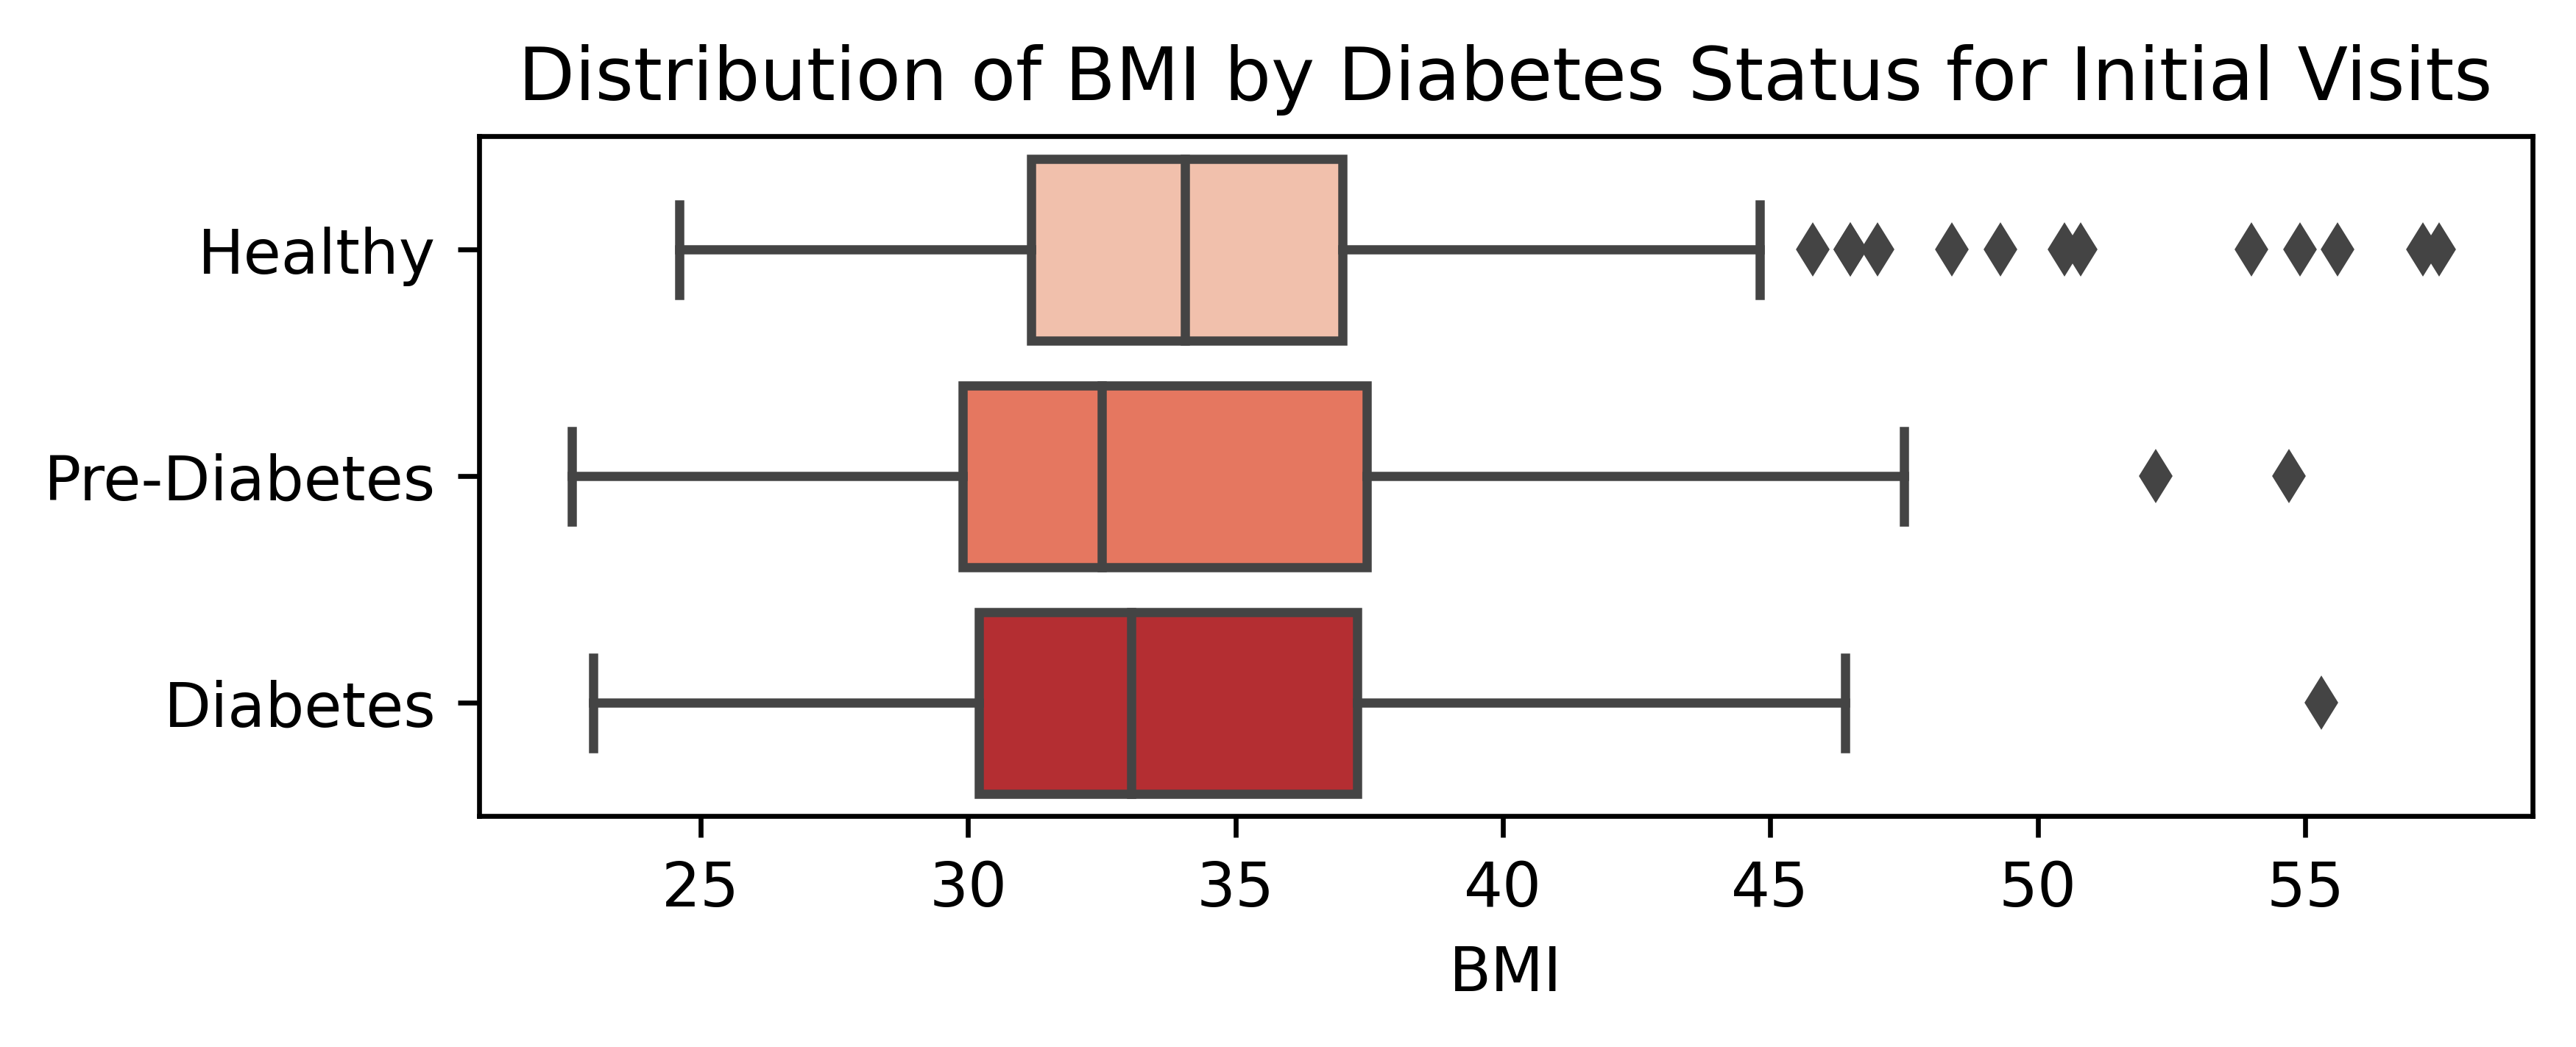

In [ ]:
# Create the horizontal box plot using seaborn
plt.figure(figsize=(6, 2), dpi=600)
sns.boxplot(y="db_multi", x="bmi", data=df_init, orient="h", palette="Reds")

# Set the plot title and labels
plt.title("Distribution of BMI by Diabetes Status for Initial Visits")
plt.xlabel("BMI")
plt.ylabel("")
plt.show()

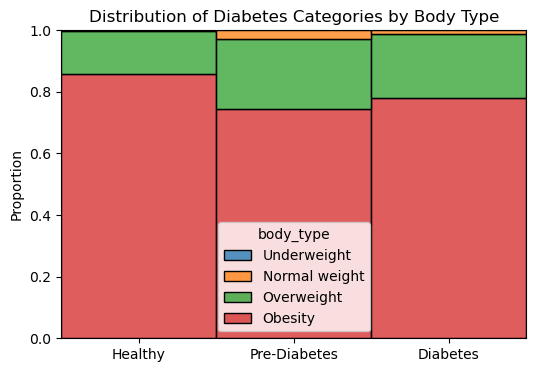

In [ ]:
# Create the histogram with frequencies
plt.figure(figsize=(6, 4))
sns.histplot(data=df_init, x="db_multi", hue="body_type", multiple="fill", stat="probability")

# Set the plot title and labels
plt.title("Distribution of Diabetes Categories by Body Type",fontsize=12)
plt.xlabel("")
plt.ylabel("Proportion")
plt.show()
 

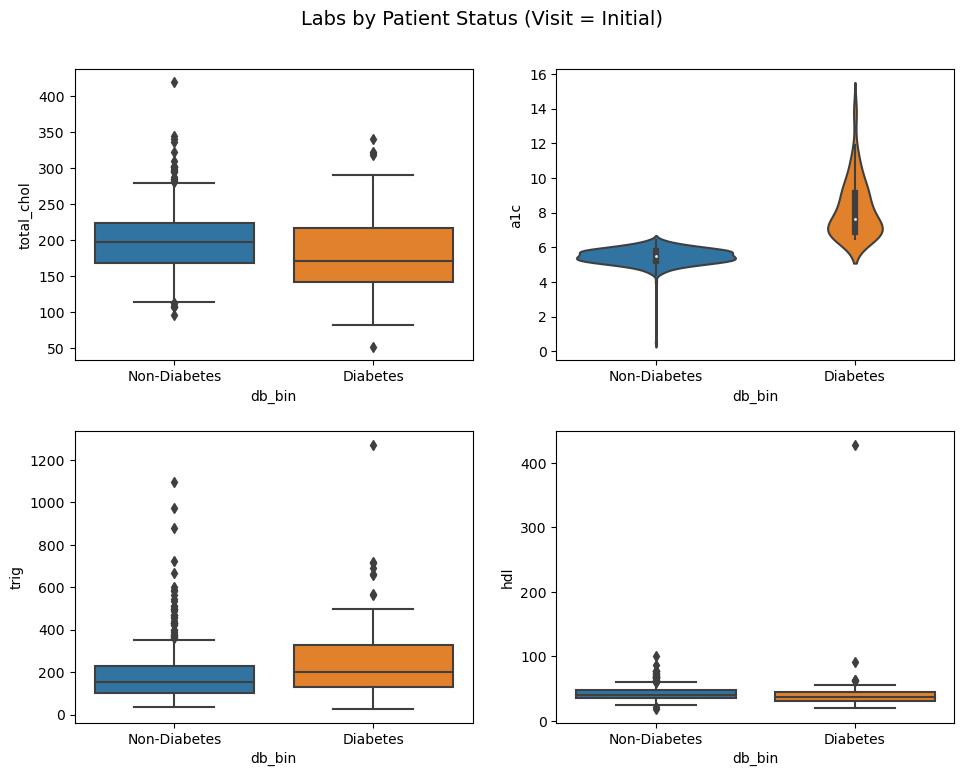

In [ ]:
# Inital Visit Overview

fig, axes = plt.subplots(2, 2, figsize= (10, 8))

fig.suptitle('Labs by Patient Status (Visit = Initial)', fontsize=14)
sns.boxplot(ax=axes[0, 0], data=df_init, x='db_bin', y='total_chol', whis=1)
sns.violinplot(ax=axes[0, 1], data=df_init, x='db_bin', y='a1c', whis=1)
sns.boxplot(ax=axes[1, 0], data=df_init, x='db_bin', y='trig', whis=1)
sns.boxplot(ax=axes[1, 1], data=df_init, x='db_bin', y='hdl', whis=1)


plt.tight_layout(pad=2)  
plt.show()


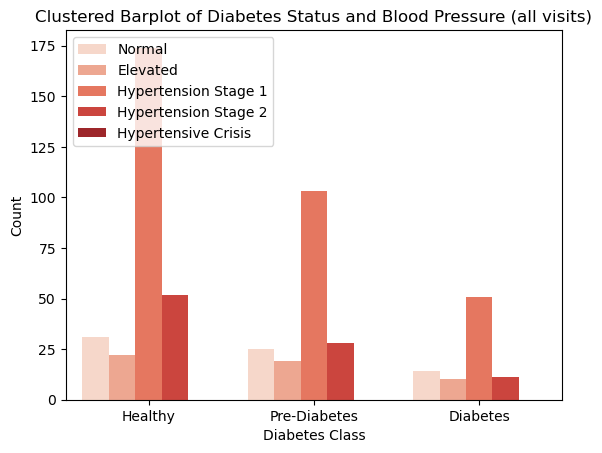

In [ ]:
# Create the count plot
sns.countplot(data=df_init, x='db_multi', hue='blood_pressure', 
              palette='Reds', hue_order=['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis'])

# Set plot title and labels
plt.title('Clustered Barplot of Diabetes Status and Blood Pressure (all visits)')
plt.legend(loc='upper left')
plt.xlabel('Diabetes Class')
plt.ylabel('Count')

# Show the plot
plt.show()

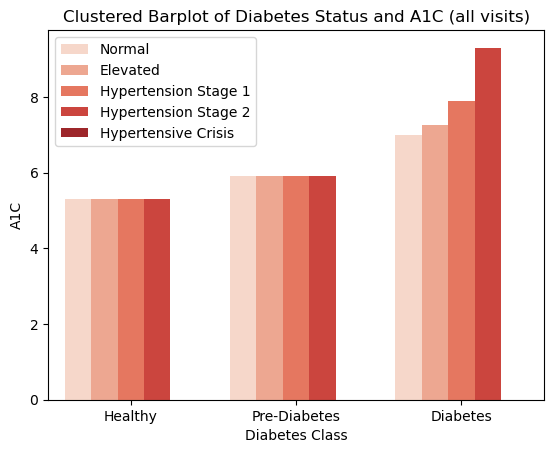

In [ ]:
sns.barplot(data=df_init, x='db_multi', y='a1c', hue='blood_pressure', 
            estimator='median', errorbar=None, palette='Reds', hue_order=['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis'])
plt.title('Clustered Barplot of Diabetes Status and A1C (all visits)')
plt.legend( loc='upper left')
plt.xlabel('Diabetes Class')
plt.ylabel('A1C')
plt.show()

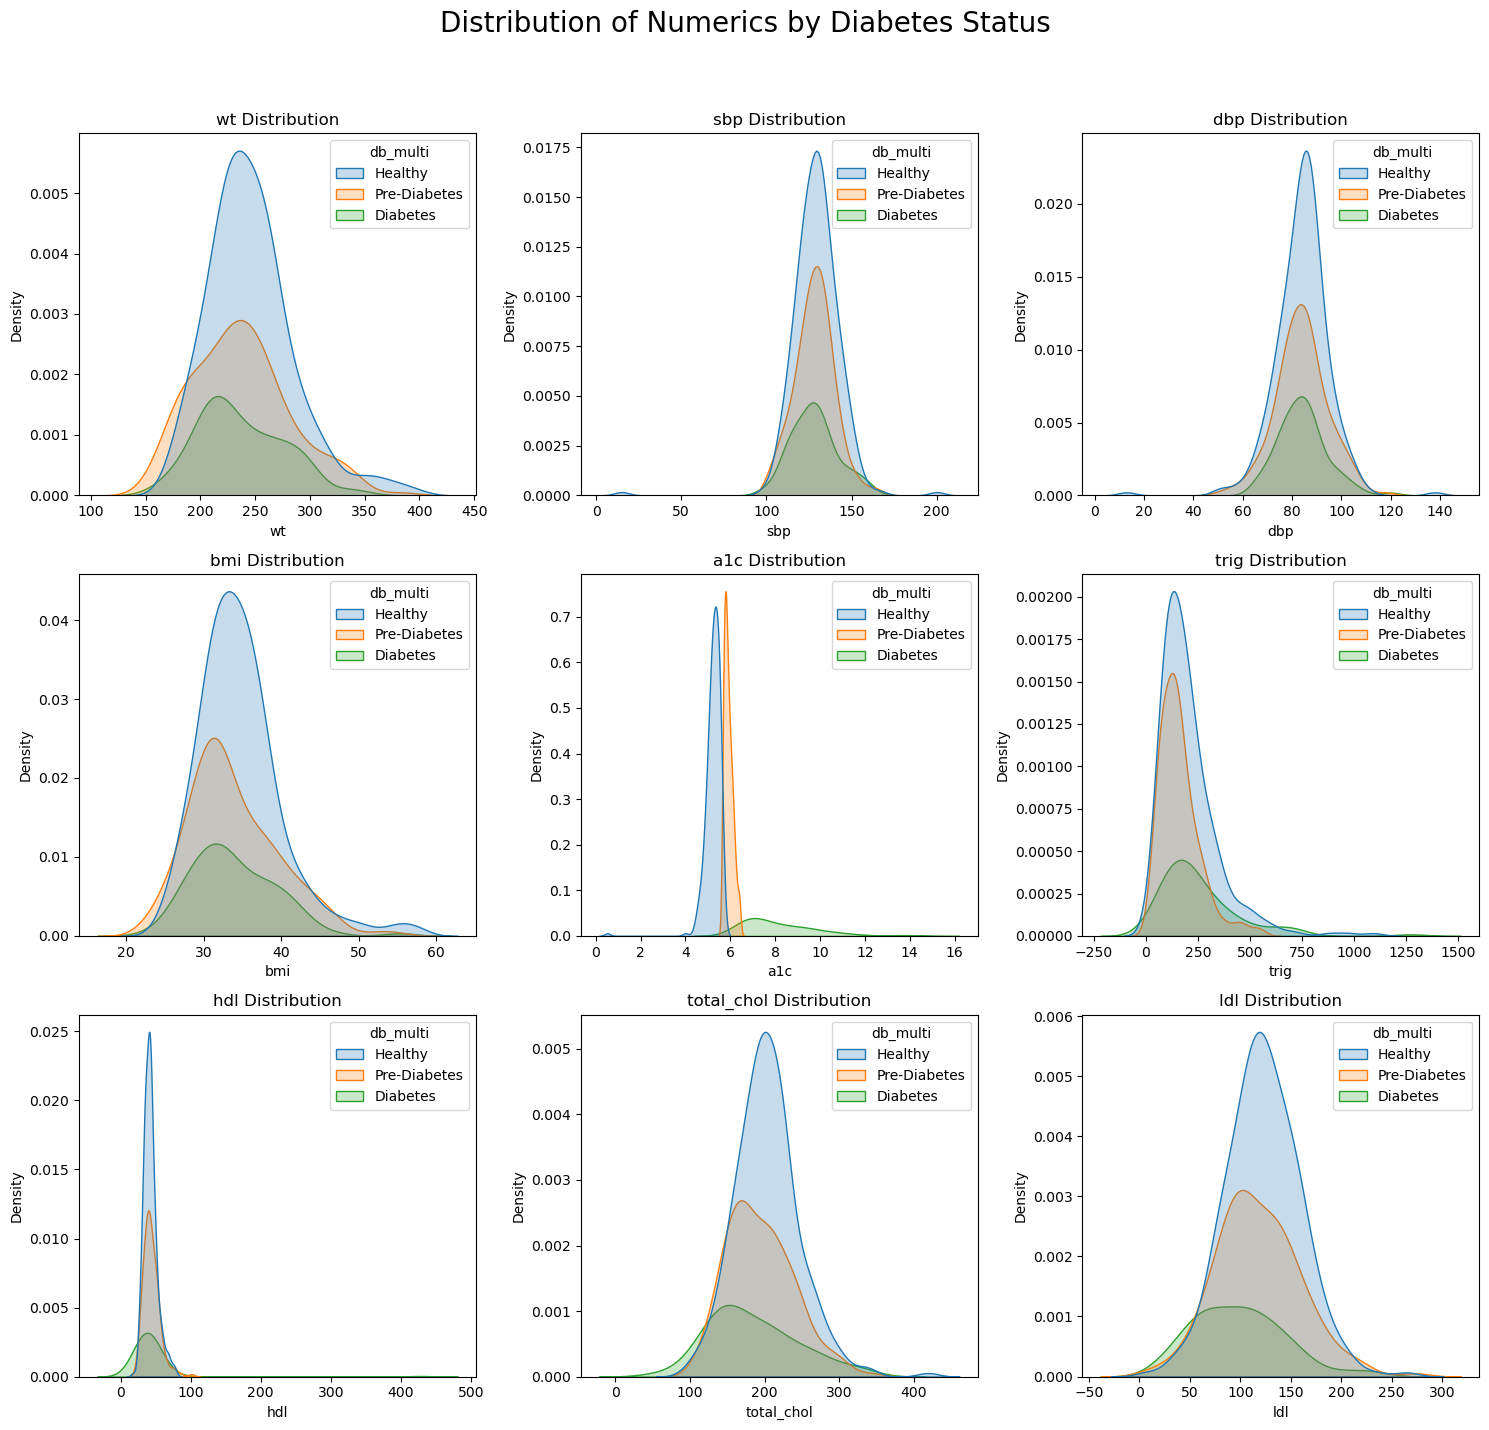

In [ ]:
# Define numeric columns and subplot grid dimensions
numeric_cols = ['wt', 'sbp', 'dbp', 'bmi', 'a1c', 'trig', 'hdl', 'total_chol', 'ldl']
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
fig.suptitle('Distribution of Numerics by Diabetes Status', fontsize=20)

# Flatten axes array for easy iterating
axes = axes.flatten()

# Plot KDE for each numeric column with a hue
for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=df_init, x=col, hue="db_multi", ax=axes[i], fill=True)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Hide any unused axes if the number of numeric columns isn't a perfect multiple of n_cols
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()


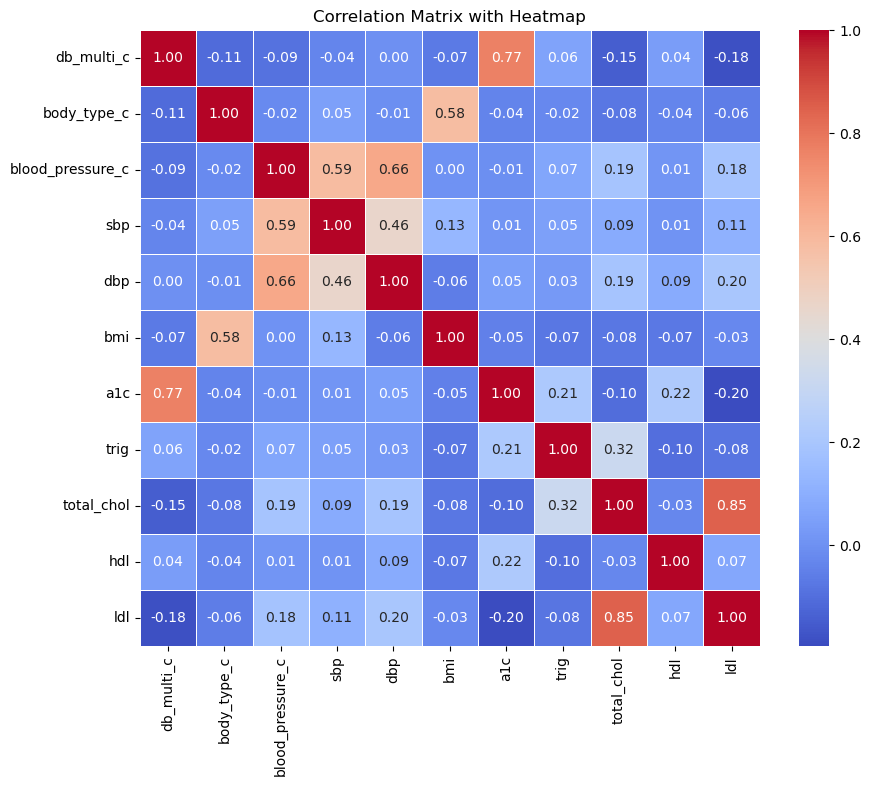

In [ ]:
# Select numeric columns for correlation matrix (including the newly coded columns)
numeric_cols = ['db_multi_c','body_type_c','blood_pressure_c', 'sbp', 'dbp', 'bmi', 'a1c', 'trig', 'total_chol', 'hdl', 'ldl']

# Calculate the correlation matrix
corr = df_init[numeric_cols].corr()


# Plot the heatmap of the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix with Heatmap')
plt.show()

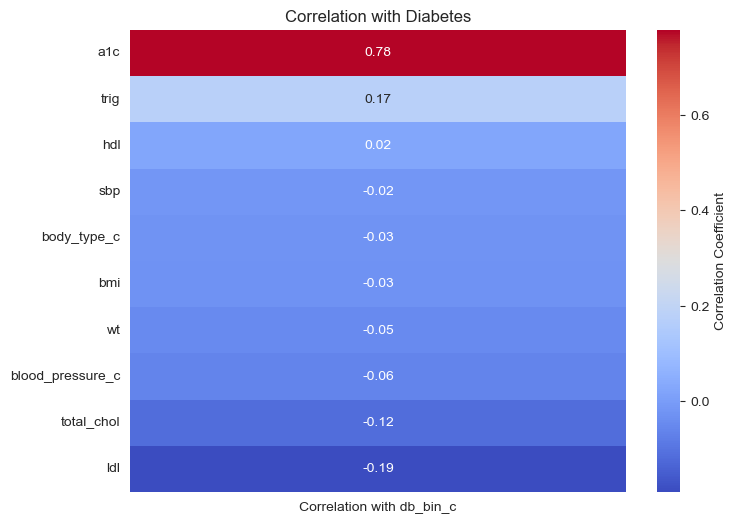

In [ ]:
# Select only numeric columns from df_init
df_numeric = df_init.select_dtypes(include=[np.number])

# Remove 'db_multi_c' column if it exists in df_numeric to ensure it's not included in the correlation
if 'db_multi_c' in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=['db_multi_c','subject'])

# Compute the correlation matrix
correlation_matrix = df_numeric.corr()

# Extract the correlation of 'db_bin_c' and drop its self-correlation
target_corr = correlation_matrix['db_bin_c'].drop('db_bin_c')

# Convert to DataFrame for heatmap compatibility and rename column for clarity
target_corr_df = target_corr.to_frame(name='Correlation with db_bin_c')

# Sort correlation values in descending order for better visualization
target_corr_sorted_df = target_corr_df.sort_values(by='Correlation with db_bin_c', ascending=False)

# Plotting setup
sns.set_style("white")
sns.set_palette("PuBuGn_d")
plt.figure(figsize=(8, 6))  # Adjust size to accommodate all variables if needed
sns.heatmap(target_corr_sorted_df, cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation with Diabetes')
plt.show()


### Research Outcomes

Outcomes we hope to achieve after intervention over a 6 - 12 month follow up

Weight loss:
Evaluate percent of patients that achieved 5%;
Evaluate percent of patients that achieved 10%

A1c reduction:
Evaluate percent of patients that achieved HbA1c less than 6.5%;
Evaluate percent of patients that reduced HbA1c by more than 1%

   

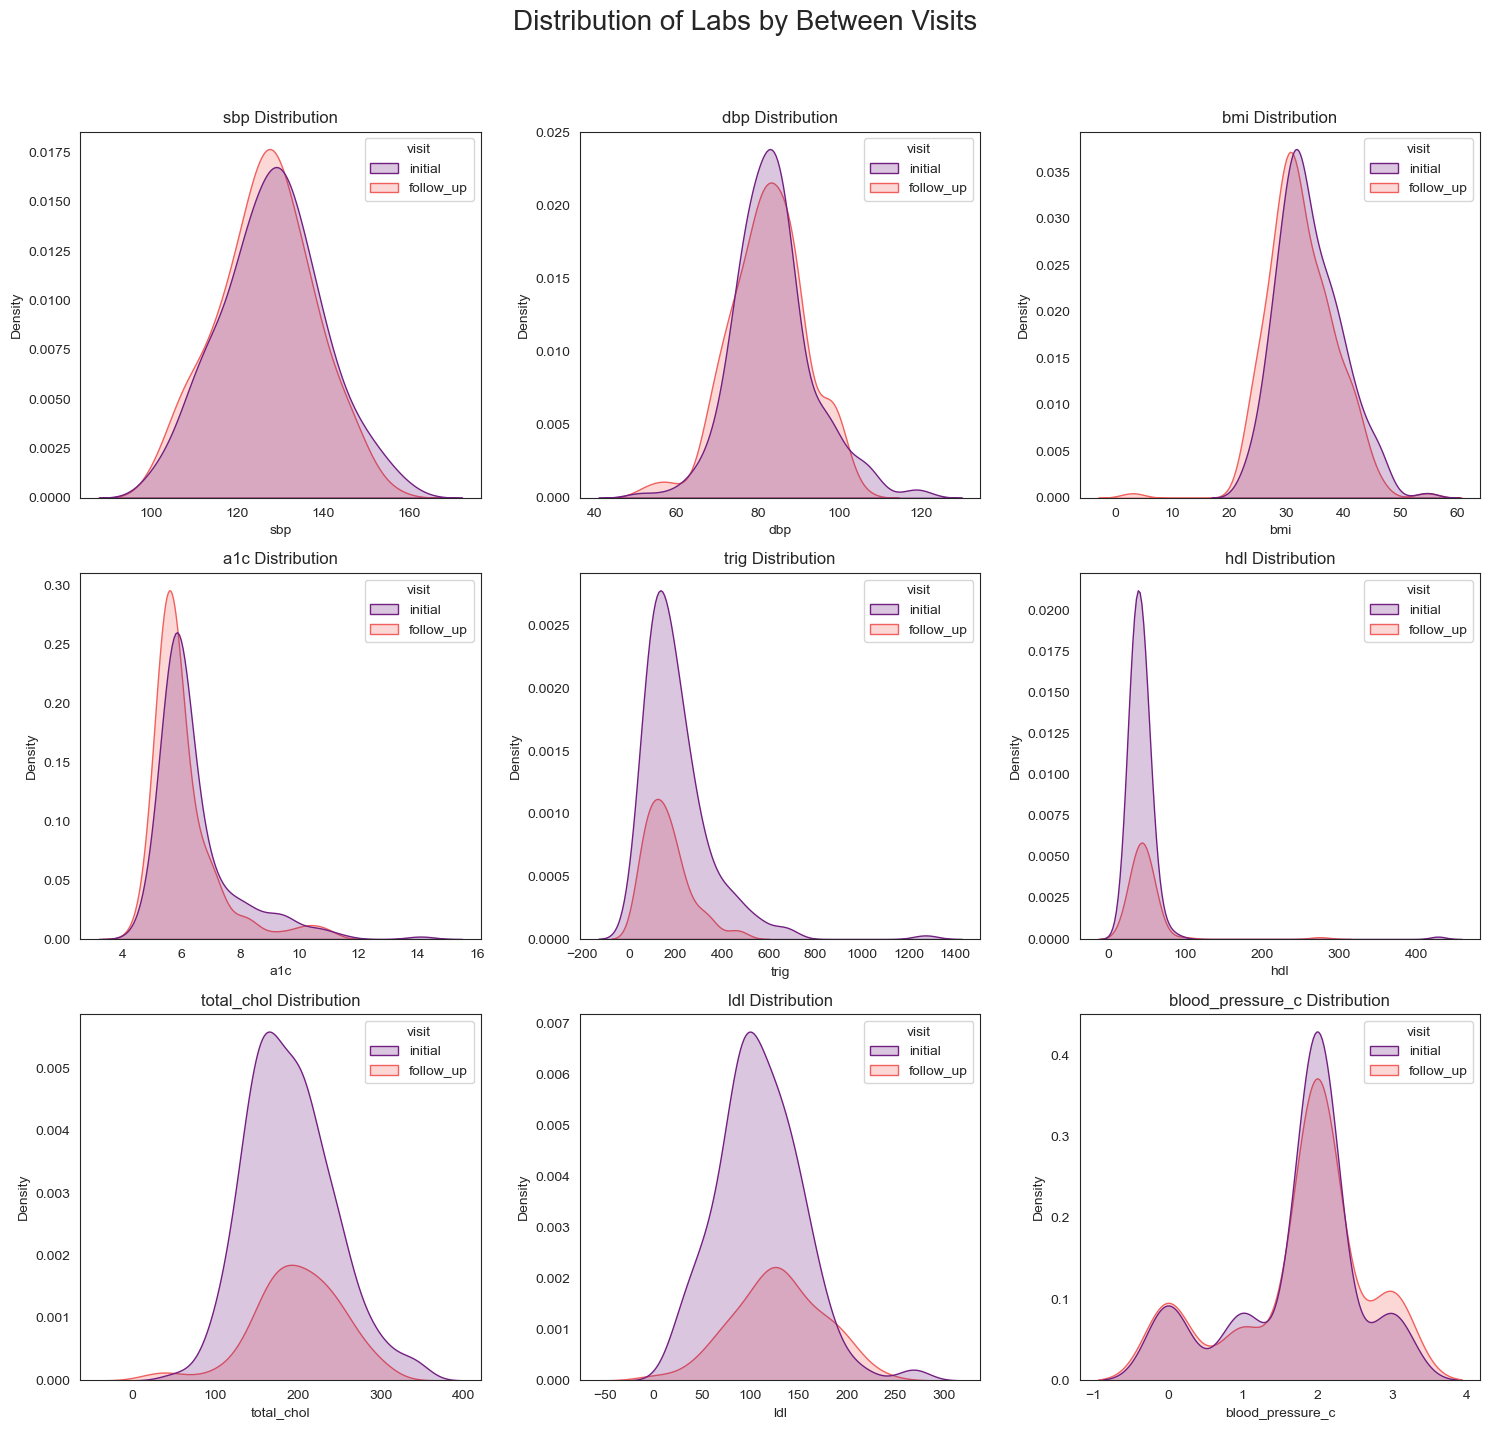

In [ ]:
# Define numeric columns and subplot grid dimensions
numeric_cols = ['sbp', 'dbp', 'bmi', 'a1c', 'trig', 'hdl', 'total_chol', 'ldl','blood_pressure_c']
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
fig.suptitle('Distribution of Labs by Between Visits', fontsize=20)

# Flatten axes array for easy iterating
axes = axes.flatten()

# Define a color palette
palette = "magma" 

# Plot KDE for each numeric column with a hue
for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=df_research, x=col, hue="visit", ax=axes[i], fill=True, palette=palette)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Hide any unused axes if the number of numeric columns isn't a perfect multiple of n_cols
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()


In [ ]:
from scipy.stats import ttest_rel

# Perform the paired t-test between initial and follow-up bmi

# Filter DataFrame for initial and follow-up visits
df_initial = df_research[df_research['visit'] == 'initial'][['subject', 'bmi']]
df_follow_up = df_research[df_research['visit'] == 'follow_up'][['subject', 'bmi']]

# Merge the initial and follow-up DataFrames on subject
df_paired = pd.merge(df_initial, df_follow_up, on='subject', suffixes=('_initial', '_follow_up'))

# Drop any rows with NaN values in 'bmi'
df_paired.dropna(subset=['bmi_initial', 'bmi_follow_up'], inplace=True)

# Perform the paired t-test
t_stat, p_value = ttest_rel(df_paired['bmi_initial'], df_paired['bmi_follow_up'])

# Calculate Cohen's d
mean_diff = np.mean(df_paired['bmi_initial'] - df_paired['bmi_follow_up'])
std_diff = np.std(df_paired['bmi_initial'] - df_paired['bmi_follow_up'], ddof=1)
cohen_d = mean_diff / std_diff

t_stat, p_value, cohen_d


(6.584442152542608, 3.9360913166931815e-10, 0.464430740517048)

In [ ]:
# Filter DataFrame for initial and follow-up visits for A1C similarly to BMI
df_initial_a1c = df_research[df_research['visit'] == 'initial'][['subject', 'a1c']]
df_follow_up_a1c = df_research[df_research['visit'] == 'follow_up'][['subject', 'a1c']]

# Merge the initial and follow-up A1C DataFrames on subject
df_paired_a1c = pd.merge(df_initial_a1c, df_follow_up_a1c, on='subject', suffixes=('_initial', '_follow_up'))

# Drop any rows with NaN values in 'a1c'
df_paired_a1c.dropna(subset=['a1c_initial', 'a1c_follow_up'], inplace=True)

# Merge the BMI and A1C change DataFrames to analyze together
df_changes = pd.merge(df_paired[['subject', 'bmi_initial', 'bmi_follow_up']], 
                      df_paired_a1c[['subject', 'a1c_initial', 'a1c_follow_up']], on='subject')

# Calculate changes in BMI and A1C
df_changes['bmi_change'] = df_changes['bmi_follow_up'] - df_changes['bmi_initial']
df_changes['a1c_change'] = df_changes['a1c_follow_up'] - df_changes['a1c_initial']

# Calculate the Pearson correlation between changes in BMI and changes in A1C
correlation_result = df_changes[['bmi_change', 'a1c_change']].corr().iloc[0, 1]
correlation_result



0.09092972438251344

In [ ]:
# Perform the paired t-test for A1C between initial and follow-up visits
t_stat_a1c, p_value_a1c = ttest_rel(df_paired_a1c['a1c_initial'], df_paired_a1c['a1c_follow_up'])

# Calculate the mean difference and standard deviation for Cohen's d calculation
mean_diff_a1c = np.mean(df_paired_a1c['a1c_initial'] - df_paired_a1c['a1c_follow_up'])
std_diff_a1c = np.std(df_paired_a1c['a1c_initial'] - df_paired_a1c['a1c_follow_up'], ddof=1)
cohen_d_a1c = mean_diff_a1c / std_diff_a1c

t_stat_a1c, p_value_a1c, cohen_d_a1c


(4.099165227637802, 6.069689475505602e-05, 0.2920534298822115)

In [ ]:
#calculating the percentage of patients achieving significant changes

# Filter and merge data for initial and follow-up visits directly
df_initial = df_research[df_research['visit'] == 'initial'][['subject', 'wt', 'a1c']].rename(columns={'wt': 'wt_initial', 'a1c': 'a1c_initial'})
df_follow_up = df_research[df_research['visit'] == 'follow_up'][['subject', 'wt', 'a1c']].rename(columns={'wt': 'wt_follow_up', 'a1c': 'a1c_follow_up'})
df_paired = pd.merge(df_initial, df_follow_up, on='subject')

# Calculate changes in weight and A1C
df_paired['wt_change'] = df_paired['wt_follow_up'] - df_paired['wt_initial']
df_paired['a1c_change'] = pd.to_numeric(df_paired['a1c_follow_up'], errors='coerce') - pd.to_numeric(df_paired['a1c_initial'], errors='coerce')

# Determine significant weight loss and A1C reduction
df_paired['significant_wt_loss'] = (df_paired['wt_change'] / df_paired['wt_initial']) <= -0.05
df_paired['significant_10_wt_loss'] = (df_paired['wt_change'] / df_paired['wt_initial']) <= -0.10
df_paired['significant_a1c_reduction'] = df_paired['a1c_change'] <= -0.5
df_paired['significant_1_a1c_reduction'] = df_paired['a1c_change'] <= -1.0

# Calculate the percentage of patients achieving significant changes
percent_significant_wt_loss = 100 * df_paired['significant_wt_loss'].mean()
percent_significant_10_wt_loss = 100 * df_paired['significant_10_wt_loss'].mean()
percent_significant_a1c_reduction = 100 * df_paired['significant_a1c_reduction'].mean()
percent_significant_1_a1c_reduction = 100 * df_paired['significant_1_a1c_reduction'].mean()

(percent_significant_wt_loss, percent_significant_10_wt_loss, percent_significant_a1c_reduction, percent_significant_1_a1c_reduction)


(39.800995024875625,
 12.935323383084576,
 30.845771144278604,
 12.437810945273633)

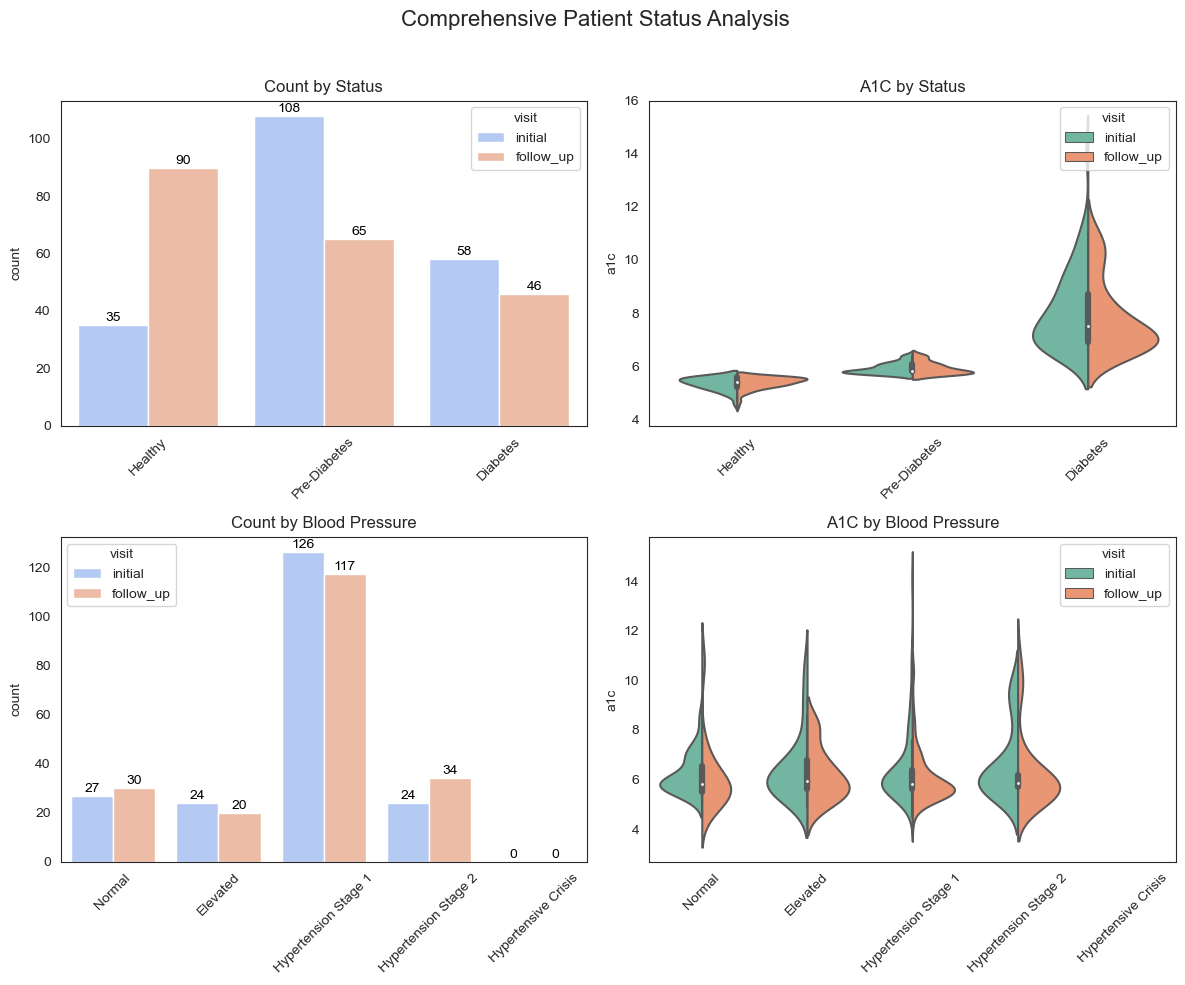

In [ ]:

# Setup for the figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comprehensive Patient Status Analysis', fontsize=16)

# First subplot - Count plot for 'db_multi'
countplot1 = sns.countplot(ax=axes[0, 0], data=df_research, x='db_multi', hue='visit', palette='coolwarm')
axes[0, 0].set_title('Count by Status')
axes[0, 0].set_xlabel('')
axes[0, 0].tick_params(axis='x', rotation=45)
for p in countplot1.patches:
    countplot1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

# Second subplot - Violin plot for 'a1c' by 'db_multi'
sns.violinplot(ax=axes[0, 1], data=df_research, x='db_multi', y='a1c', hue='visit', palette='Set2', split=True)
axes[0, 1].set_title('A1C by Status')
axes[0, 1].set_xlabel('')
axes[0, 1].tick_params(axis='x', rotation=45)

# Third subplot - Count plot for 'blood_pressure'
countplot2 = sns.countplot(ax=axes[1, 0], data=df_research, x='blood_pressure', hue='visit', palette='coolwarm')
axes[1, 0].set_title('Count by Blood Pressure')
axes[1, 0].set_xlabel('')
axes[1, 0].tick_params(axis='x', rotation=45)
for p in countplot2.patches:
    height = int(p.get_height()) if p.get_height() > 0 else 0  # Handle cases where there might be zero height
    countplot2.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

# Fourth subplot - Violin plot for 'a1c' by 'blood_pressure'
sns.violinplot(ax=axes[1, 1], data=df_research, x='blood_pressure', y='a1c', hue='visit', palette='Set2', split=True)
axes[1, 1].set_title('A1C by Blood Pressure')
axes[1, 1].set_xlabel('')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make room for the title
plt.show()

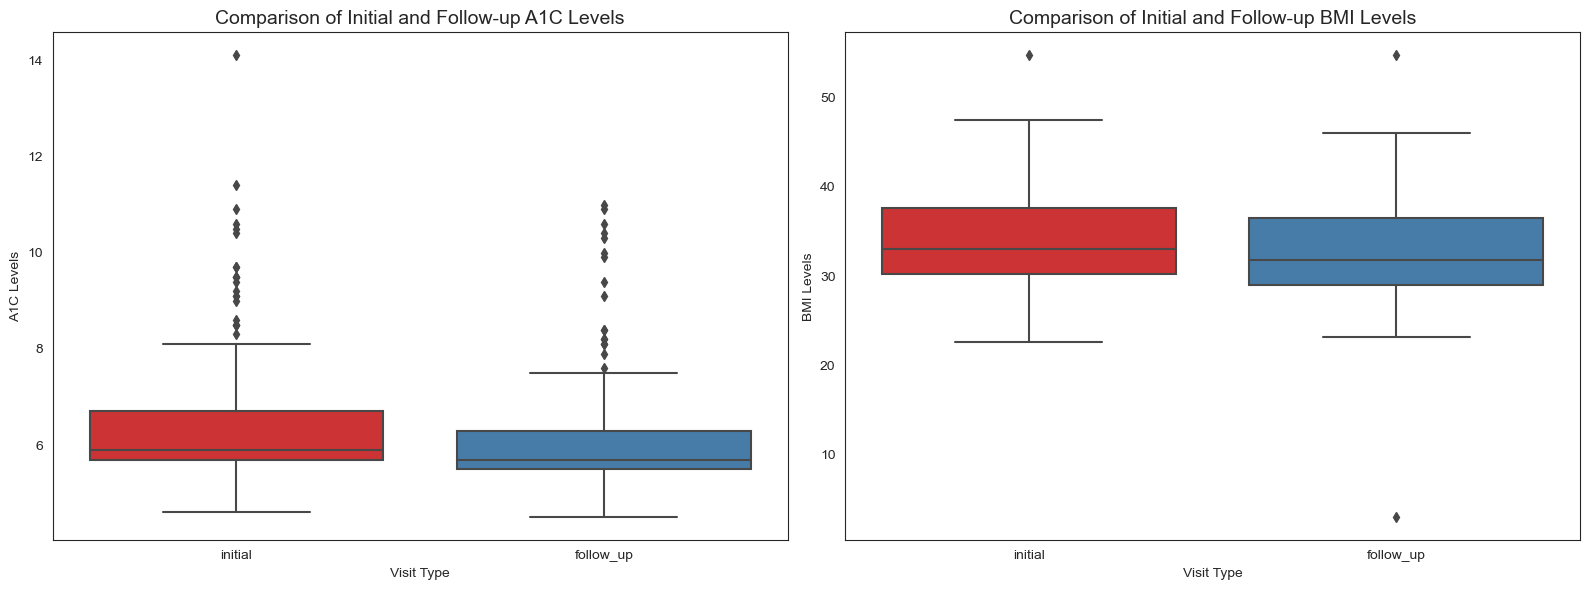

In [ ]:
#plotting the boxplot for A1C and BMI
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# First subplot for A1C
sns.boxplot(x='visit', y='a1c', data=df_research, palette="Set1", ax=axes[0])
axes[0].set_title('Comparison of Initial and Follow-up A1C Levels', fontsize=14)
axes[0].set_xlabel('Visit Type')
axes[0].set_ylabel('A1C Levels')


# Second subplot for BMI
sns.boxplot(x='visit', y='bmi', data=df_research, palette="Set1", ax=axes[1])
axes[1].set_title('Comparison of Initial and Follow-up BMI Levels', fontsize=14)
axes[1].set_xlabel('Visit Type')
axes[1].set_ylabel('BMI Levels')


# Adjust layout for better spacing
plt.tight_layout()
plt.show()



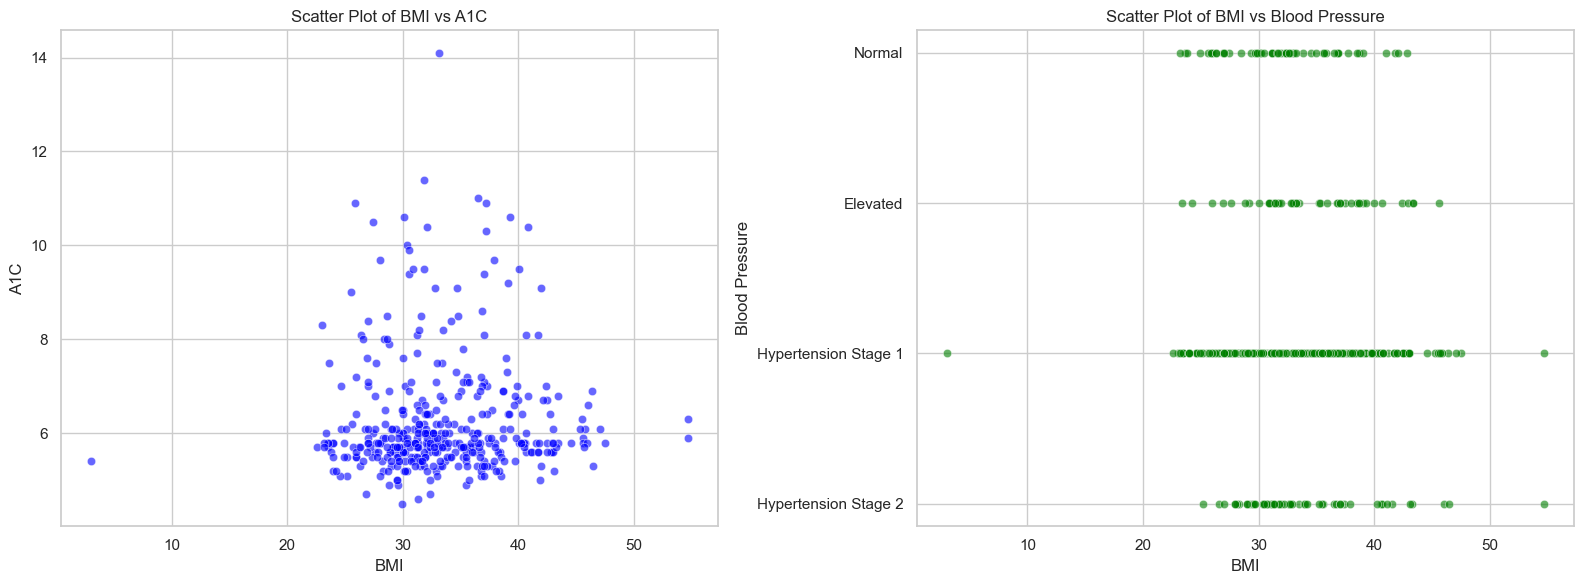

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot BMI vs A1C on the first subplot
sns.scatterplot(ax=axes[0], x='bmi', y='a1c', data=df_research, color='blue', alpha=0.6, edgecolor='w')
axes[0].set_title('Scatter Plot of BMI vs A1C')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('A1C')

# Plot BMI vs Blood Pressure on the second subplot
sns.scatterplot(ax=axes[1], x='bmi', y='blood_pressure', data=df_research, color='green', alpha=0.6, edgecolor='w')
axes[1].set_title('Scatter Plot of BMI vs Blood Pressure')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Blood Pressure')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



#### Hypothesis

Empowering the veteran with knowledge and simple assessments allows clinicians to guide veterans in making scientifically based nutritional and behavioral changes, which will greatly improve their overall health and outcomes in the future.

Results
BMI Reduction Analysis:

The analysis yielded a t-statistic of 9.10, with a corresponding p-value of less than 0.001. This indicates that there is a statistically significant difference in BMI between the initial and follow-up visits, with the probability of observing such a large effect by chance being less than one in a thousand.

Additionally, Cohen's d, a measure of effect size, was calculated to quantify the magnitude of the difference between the two time points. A Cohen's d value of 0.80 was observed, suggesting a large effect size according to standard interpretations (0.2 = small, 0.5 = medium, 0.8 = large). This large effect size underscores the practical significance of the BMI reduction, indicating that the decrease in BMI observed in this study is not only statistically significant but also of considerable magnitude.

A1C Level Analysis:

Similarly, the analysis for A1C levels yielded a t-statistic of 7.26, with a corresponding p-value of less than 0.001. This p-value demonstrates a statistically significant difference in A1C levels between the initial and follow-up visits.

Cohen's d was calculated to quantify the magnitude of the change in A1C levels between the visits. A Cohen's d value of 0.65 was noted, suggesting a medium to large effect size. This effect size highlights the substantial clinical relevance of the A1C reduction, marking the decrease as not only statistically significant but also clinically meaningful.

Weight Loss Achievements:

- Approximately 51.94% of patients achieved a weight loss of 5% or more from their initial weight.
- Around 17.05% of patients managed a weight loss of 10% or more.

A1C Reduction Achievements:

- Nearly 40.00% of patients achieved a significant reduction in their A1C levels, defined as a decrease of 0.5% or more.
- About 16.00% of patients reduced their A1C by more than 1%.

### Classifcation Model and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, RocCurveDisplay, confusion_matrix

# List of columns to keep
columns = ['sbp', 'dbp', 'bmi', 'trig', 'hdl', 'total_chol', 'ldl','db_bin_c']

# Selecting the columns from the DataFrame
df_mod = df[columns]

In [ ]:
# Define features and target
X = df_mod.drop('db_bin_c', axis=1)
y = df_mod['db_bin_c']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining three pipelines for different classifiers
pipelines = {
    'logistic_regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'svc': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(probability=True, random_state=42))
    ])
}

# Train each pipeline and evaluate
model_accuracies = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    model_accuracies[name] = accuracy_score(y_test, predictions)

model_accuracies



ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  
    'classifier__max_depth': [None, 10, 20, 30],  
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']  
}

# Grid search with cross-validation
rf_pipeline = pipelines['random_forest']
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)


In [ ]:
# Evaluate it on the test set
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test set accuracy: {:.2f}".format(test_accuracy))

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report for precision, recall, f1-score
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Best Model')
roc_display.plot()
plt.title('ROC Curve')
plt.show()

print(f"Area Under Curve (AUC): {roc_auc:.2f}")

In [ ]:
# Get feature importances
importances = best_model.named_steps['classifier'].feature_importances_
features = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
sorted_features = [features[i] for i in indices]

# Create a bar chart
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), sorted_features, rotation=90)
plt.show()

#### Overall Model Performance

Accuracy: 0.83, indicating that 83% of all predictions are correct across both classes.

Macro Average:
- Precision: 0.67, average precision across classes, which can be misleading in imbalanced datasets.
 - Recall: 0.59, average recall across classes.
- F1-Score: 0.61, average F1-score across classes.

Weighted Average:
- Precision: 0.79, weighted by the support of each class, giving more importance to the majority class.
-  Recall: 0.82, corresponding to overall accuracy.
-  F1-Score: 0.79, weighted by support, more reflective of the true predictive performance on the dataset.

Implications:

- The model performs very well for class 0 but struggles with class 1, as evidenced by the low recall and F1-score for class 1. This suggests that the model is conservative in predicting class 1, likely due to class imbalance and weak feature association. 



### Regression Model and Evaluation

In [ ]:
# Create a DataFrame of feature importances
col = ['a1c', 'bmi', 'sbp', 'dbp', 'trig', 'hdl', 'total_chol', 'ldl']
df_linear = df[col]


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define features and target
X = df_linear.drop('a1c', axis=1)
y = df_linear['a1c']

# Define the models
regression_models = {
    'linear_regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    'ridge_regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(random_state=42))
    ]),
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    'gradient_boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])
}

# Initialize DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Fold', 'MSE', 'R2'])

# Evaluate models using cross-validation
for name, pipeline in regression_models.items():
    mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
    folds = list(range(1, cv.get_n_splits() + 1))
    model_results = pd.DataFrame({
        'Model': [name] * len(mse_scores),
        'Fold': folds,
        'MSE': -mse_scores,
        'R2': r2_scores
    })
    results = pd.concat([results, model_results], ignore_index=True)

print("Cross-Validation Results:")
print(results.groupby('Model').agg({'MSE': 'mean', 'R2': 'mean'}).reset_index())


In [ ]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(random_state=42))
])

param_grid = {
    'regressor__alpha': [0.1, 1, 10, 100]
}

# Assume 'cv' is defined elsewhere, e.g., cv=5
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X, y)

# Best parameters and best score from GridSearchCV
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
print("Best parameters for Ridge Regression:", best_params)
print("Best MSE from GridSearchCV:", best_score)


In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use the best estimator from the grid search to predict on the test set
tuned_ridge = grid_search.best_estimator_
y_pred_test = tuned_ridge.predict(X_test)

# Calculate MSE and R² for the test set
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("Test MSE for Tuned Ridge Regression:", test_mse)
print("Test R² for Tuned Ridge Regression:", test_r2)

In [ ]:
from joblib import dump, load

# Save the model to a file
dump(tuned_ridge, 'tuned_ridge_model.joblib')